# A Behavior Sequence Transformer For Movie Recommendation

**Author:** [Nelson Lin](https://www.linkedin.com/in/nelson-lin-842564164/)<br>
**Date created:** 2024/07/09<br>
**Last modified:** 2024/07/09<br>
**Description:** Rating rate prediction using the Behavior Sequence Transformer (BST) model on the Movielens 1M.

## (1) Notebook Settings

In [1]:
import pandas as pd
import os
import numpy as np
import torch
from torch import nn
from zipfile import ZipFile
from urllib.request import urlretrieve
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import random
import json
from sklearn import metrics

In [2]:
# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


## (2) Data preparation

### Load Data

In [3]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
ZipFile("movielens.zip", "r").extractall()

In [4]:
users = pd.read_csv(
    "ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"],
    engine='python'
)

ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
    engine='python'
)

movies = pd.read_csv(
    "ml-1m/movies.dat", sep="::", names=["movie_id", "title", "genres"],
    engine='python',encoding='ISO-8859-1'
)

### Remap ID to index

In [5]:
# remap the id to index
def generate_remap_id_dict(df,col):
    ids = df[df[col].notnull()][col].unique().tolist()
    ids = sorted(ids)
    id_map_dict = {x: i+1 for i, x in enumerate(ids)}
    id_map_dict["UNK"]=0

    df[f"{col}_index"] = df[col].fillna("UNK").map(id_map_dict)

    return id_map_dict

In [6]:
user_id_map_dict = generate_remap_id_dict(users,col='user_id')

In [7]:
users.head()

,user_id,sex,age_group,occupation,zip_code,user_id_index
0,1,F,1,10,48067,1
1,2,M,56,16,70072,2
2,3,M,25,15,55117,3
3,4,M,45,7,02460,4
4,5,M,25,20,55455,5


In [8]:
# remap sex to score
sex_id_map_dict = {'M':0.0,'F':1.0,'UNK':0.5}
users['sex']=users['sex'].map(sex_id_map_dict)

In [9]:
occupation_id_map_dict = generate_remap_id_dict(users,col='occupation')

In [10]:
age_group_id_map_dict = generate_remap_id_dict(users,col='age_group')

In [11]:
min_max_scaler = MinMaxScaler()
ratings["norm_rating"] = min_max_scaler.fit_transform(
    ratings["rating"].values.reshape(-1, 1))[:, 0]

In [12]:
movie_id_map_dict = generate_remap_id_dict(movies,col='movie_id')

In [13]:
genres_set = set()
def get_genres_set(genres):
    global genres_set
    genres_split = genres.split("|")
    genres_set.update(genres_split)
    return genres_split
movies['genres'] = movies['genres'].apply(lambda x:get_genres_set(x))
genres_map_dict ={x: i+1 for i, x in enumerate(sorted(genres_set))}
genres_map_dict['UNK']=0

In [14]:
movies['genres_ids']= movies['genres'].apply(lambda x: [genres_map_dict[g] for g in x])

In [15]:
ratings['movie_id_index'] = ratings['movie_id'].map(movie_id_map_dict)
ratings['user_id_index'] = ratings['user_id'].map(user_id_map_dict)

In [16]:
df_user_views = ratings[["movie_id_index", "user_id_index", "unix_timestamp", "norm_rating"]] \
    .merge(movies[['movie_id_index', 'genres_ids']],
           on=['movie_id_index'])

In [17]:
df_user_views.head()

,movie_id_index,user_id_index,unix_timestamp,norm_rating,genres_ids
0,1177,1,978300760,1.00,[8]
1,1177,2,978298413,1.00,[8]
2,1177,12,978220179,0.75,[8]
3,1177,15,978199279,0.75,[8]
4,1177,17,978158471,1.00,[8]


### Prepare the Sequence

In [18]:
df_agg_ratings = df_user_views.sort_values(by=["unix_timestamp"]).groupby("user_id_index")

In [19]:
ratings_data = pd.DataFrame(
    data={
        "user_id_index": list(df_agg_ratings.groups.keys()),
        "movie_sequence": list(df_agg_ratings.movie_id_index.apply(list)),
        "rating_sequence": list(df_agg_ratings.norm_rating.apply(list)),
        "timestamps": list(df_agg_ratings.unix_timestamp.apply(list)),
    }
)

In [20]:
sequence_length = 4
step_size = 2


def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            seq = values[-window_size:]
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences


ratings_data.movie_sequence	 = ratings_data.movie_sequence.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

ratings_data.rating_sequence = ratings_data.rating_sequence.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

del ratings_data["timestamps"]

In [21]:
ratings_data_movies = ratings_data[["user_id_index", "movie_sequence"]].explode(
    "movie_sequence", ignore_index=True
)
ratings_data_rating = ratings_data[["rating_sequence"]].explode("rating_sequence", ignore_index=True)
ratings_data_transformed = pd.concat([ratings_data_movies, ratings_data_rating], axis=1)

In [22]:
ratings_data_transformed.head()

,user_id_index,movie_sequence,rating_sequence
0,1,"[3118, 1010, 1673, 1251]","[0.75, 1.0, 0.75, 1.0]"
1,1,"[1673, 1251, 2272, 1769]","[0.75, 1.0, 0.5, 1.0]"
2,1,"[2272, 1769, 3340, 1190]","[0.5, 1.0, 0.75, 0.75]"
3,1,"[3340, 1190, 2736, 258]","[0.75, 0.75, 1.0, 0.75]"
4,1,"[2736, 258, 1177, 712]","[1.0, 0.75, 1.0, 0.5]"


In [23]:
user_columns = ['user_id_index',
                'sex',
                'occupation_index',
                'age_group_index']

In [24]:
ratings_data_transformed = ratings_data_transformed.merge(
    users[user_columns], on="user_id_index"
)

In [25]:
ratings_data_transformed['sex'] = ratings_data_transformed['sex'].astype(float)

In [26]:
ratings_data_transformed['target_movie'] =  ratings_data_transformed['movie_sequence'].apply(lambda x:x[-1])
ratings_data_transformed['target_rating'] =  ratings_data_transformed['rating_sequence'].apply(lambda x:x[-1])
# mask the last rating
mask_score = 1.0
ratings_data_transformed['rating_sequence'] =  ratings_data_transformed['rating_sequence'].apply(lambda x:x[:-1]+[mask_score])

In [27]:
ratings_data_transformed.head()

,user_id_index,movie_sequence,rating_sequence,sex,occupation_index,age_group_index,target_movie,target_rating
0,1,"[3118, 1010, 1673, 1251]","[0.75, 1.0, 0.75, 1.0]",1.0,11,1,1251,1.00
1,1,"[1673, 1251, 2272, 1769]","[0.75, 1.0, 0.5, 1.0]",1.0,11,1,1769,1.00
2,1,"[2272, 1769, 3340, 1190]","[0.5, 1.0, 0.75, 1.0]",1.0,11,1,1190,0.75
3,1,"[3340, 1190, 2736, 258]","[0.75, 0.75, 1.0, 1.0]",1.0,11,1,258,0.75
4,1,"[2736, 258, 1177, 712]","[1.0, 0.75, 1.0, 1.0]",1.0,11,1,712,0.50


In [28]:
random_selection = np.random.rand(len(ratings_data_transformed.index)) <= 0.85
train_data = ratings_data_transformed[random_selection]
test_data = ratings_data_transformed[~random_selection]

## (3) Model Config

In [29]:
num_user = len(user_id_map_dict)
num_movie = len(movie_id_map_dict)
num_occupation = len(occupation_id_map_dict)
num_age_group = len(age_group_id_map_dict)
# num_genre = len(genres_map_dict)

In [30]:
embed_configs = {}
EMED_DIM=32
sequence_length=4
embed_configs['user']={"embed_dim":EMED_DIM,"num_embed":num_user}
embed_configs['movie']={"embed_dim":EMED_DIM,"num_embed":num_movie}
embed_configs['occupation']={"embed_dim":EMED_DIM,"num_embed":num_occupation}
embed_configs['age_group']={"embed_dim":EMED_DIM,"num_embed":num_age_group}
embed_configs['position'] = {"embed_dim":EMED_DIM,"num_embed":sequence_length}

In [31]:
config_dict={}
config_dict['embed_configs'] = embed_configs
config_dict['transformer_num_layer']=3
config_dict['dropout']=0.2
config_dict['epoches']=1
config_dict['learning_rate']=0.001
config_dict['batch_size']=32

In [32]:
config_dict['device'] = "cuda" if torch.cuda.is_available() else "cpu"

In [33]:
class Config:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            setattr(self, key, value)
config = Config(dictionary=config_dict)

## (4) Create Model

In [34]:
class TransformerBlock(nn.Module):
    def __init__(self, input_size, output_size, num_heads, dropout_rate):
        super(TransformerBlock, self).__init__()

        self.multihead_attention = nn.MultiheadAttention(input_size, num_heads)
        self.layer_norm1 = nn.LayerNorm(input_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(input_size, 4*input_size),
            nn.ReLU(),
            nn.Linear(4*input_size, output_size),
            nn.Dropout(dropout_rate)
        )
        self.layer_norm2 = nn.LayerNorm(output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Multi-head Attention
        attn_output, _ = self.multihead_attention(x, x, x)
        x = self.layer_norm1(x + attn_output)

        # Feed-Forward Network
        ff_output = self.feed_forward(x)
        x = self.layer_norm2(x + ff_output)
        x = self.dropout(x)
        return x

class TransformerLayer(nn.Module):
    def __init__(self, d_model, num_heads=8, dropout_rate=0.2, num_layers=3):
        super(TransformerLayer, self).__init__()

        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, d_model, num_heads, dropout_rate)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        return x

In [35]:
class MLP(nn.Module):
    def __init__(self, dropout=0.2, hidden_units=[512, 256,128]):
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.layers = nn.ModuleList()
        for i in range(len(hidden_units) - 1):
            self.layers.append(nn.Linear(hidden_units[i], hidden_units[i + 1]))
            self.layers.append(nn.LeakyReLU())
            self.layers.append(nn.Dropout(p=dropout))
        self.fc = nn.Linear(hidden_units[-1],1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        logits = self.fc(x)
        output = self.sigmoid(logits)
        return output

In [36]:

class BSTRecommender(nn.Module):
    def __init__(self, config):
        super(BSTRecommender, self).__init__()
        self.config = config
        self.embed_configs = config.embed_configs
        self.drouput = config.dropout
        self.transformer_num_layer = config.transformer_num_layer
        self.device = config.device

        """embed_configs
        {'user': {'embed_dim': 32, 'num_embed': 6041},
        'movie': {'embed_dim': 32, 'num_embed': 3884},
        'occupation': {'embed_dim': 32, 'num_embed': 22},
        'age_group': {'embed_dim': 32, 'num_embed': 8},
        'position': {'embed_dim': 32, 'num_embed': 4}}
        """

        embed_configs = self.config.embed_configs

        """Create Embedding Layer"""
        embedding_layers = []
        for name, embed_config in embed_configs.items():
            embed_dim = embed_config['embed_dim']
            num_embed = embed_config['num_embed']
            embeding_layer = nn.Embedding(
                num_embeddings=num_embed, embedding_dim=embed_dim)
            nn.init.xavier_uniform_(embeding_layer.weight)
            embedding_layers.append([name, embeding_layer])

        self.embedding_layers = nn.ModuleDict(embedding_layers)

        transformer_dim = self.embed_configs['position']['embed_dim'] + \
            self.embed_configs['movie']['embed_dim']

        self.transformer_layer = TransformerLayer(d_model=transformer_dim,
                                                  num_heads=8,
                                                  dropout_rate=self.drouput,
                                                  num_layers=self.transformer_num_layer)

        # movie_embed_dim*2 + sequence*movie_embedding*2 + user_embed_dim*2+occupation_embed_dim*2+age_embed_dim*2+1

        sequence_length = self.embed_configs['position']['num_embed']
        mlp_dim = self.embed_configs['user']['embed_dim']*2 + \
            self.embed_configs['occupation']['embed_dim']*2 +\
            self.embed_configs['age_group']['embed_dim']*2 +\
            self.embed_configs['movie']['embed_dim']*2 +\
            transformer_dim*sequence_length+1

        self.mlp = MLP(dropout=self.drouput, hidden_units=[mlp_dim, 256, 64])

    def forward(self, inputs):

        target_movie_embedding = self.embedding_layers['movie'](
            inputs['target_movie'])
        batch_size = target_movie_embedding.shape[0]

        """Sequence Feature Engineering"""

        # movie embedding
        movie_sequence_embedding = self.embedding_layers['movie'](
            inputs['movie_sequence'])

        # position embedding
        positions = torch.arange(
            self.config.embed_configs['position']['num_embed']).to(self.device)
        position_embedding = self.embedding_layers['position'](positions)
        batch_position_embedding = torch.stack(
            [position_embedding.clone() for _ in range(batch_size)])
        # concat with position instead of adding
        movie_pos_seq_embedding = torch.concat(
            [movie_sequence_embedding, batch_position_embedding], dim=-1)
        # point wise product with sequence rating
        rating_sequence = inputs['rating_sequence']
        movie_pos_rating_seq_embedding = torch.mul(
            movie_pos_seq_embedding, rating_sequence.unsqueeze(-1))
        # feed into transformer layer
        seq_transformer_output = self.transformer_layer(
            movie_pos_rating_seq_embedding)
        seq_transformer_flatten_output = seq_transformer_output.view(
            batch_size, -1)

        """concat other features"""
        # orginal features
        sex_feature = inputs['sex'].unsqueeze(-1)
        user_embedding = self.embedding_layers['user'](inputs['user_id_index'])
        occupation_embedding = self.embedding_layers['occupation'](
            inputs['occupation_index'])
        age_group_embedding = self.embedding_layers['age_group'](
            inputs['age_group_index'])

        # cross features with target movie embedding
        sex_cross_feature = torch.mul(sex_feature, target_movie_embedding)
        user_embedding_cross = torch.mul(
            user_embedding, target_movie_embedding)
        occupation_embedding_cross = torch.mul(
            occupation_embedding, target_movie_embedding,)
        age_group_embedding_cross = torch.mul(
            age_group_embedding, target_movie_embedding)

        # shape:1+user_embed_dim+occupation_embed_dim+age_embed_dim
        user_features = torch.concat(
            [sex_feature, user_embedding, occupation_embedding, age_group_embedding], dim=-1)

        # shape:movie_embed_dim +user_embed_dim+occupation_embed_dim+age_embed_dim
        user_cross_features = torch.concat(
            [sex_cross_feature, user_embedding_cross, occupation_embedding_cross, age_group_embedding_cross], dim=-1)

        # shape:movie_embed_dim +user_embed_dim+occupation_embed_dim+age_embed_dim + 1+user_embed_dim+occupation_embed_dim+age_embed_dim
        user_inputs_features = torch.concat(
            [user_features, user_cross_features, target_movie_embedding], axis=1)
        # shape:movie_embed_dim +user_embed_dim+occupation_embed_dim+age_embed_dim + 1+user_embed_dim+occupation_embed_dim+age_embed_dim
        # sequence*movie_embedding*2+movie_embeddding
        mlp_input_features = torch.concat(
            [user_inputs_features, seq_transformer_flatten_output], axis=1)

        outputs = self.mlp(mlp_input_features)

        return outputs

In [37]:
model = BSTRecommender(config=config)

In [38]:
model = model.to(config.device)
model.train()

BSTRecommender(
  (embedding_layers): ModuleDict(
    (user): Embedding(6041, 32)
    (movie): Embedding(3884, 32)
    (occupation): Embedding(22, 32)
    (age_group): Embedding(8, 32)
    (position): Embedding(4, 32)
  )
  (transformer_layer): TransformerLayer(
    (transformer_blocks): ModuleList(
      (0-2): 3 x TransformerBlock(
        (multihead_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
        (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (mlp): MLP(
    (dropout): Dropout(p=

## (5) Load Rating Dataset

In [39]:
class RatingDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        item_dict = self.data.iloc[index].to_dict()

        dtype_dict = {}
        for k,v in item_dict.items():
            dtype_dict[k]=torch.long
        dtype_dict['rating_sequence']=torch.float32
        dtype_dict['target_rating']=torch.float32
        dtype_dict['sex']=torch.float32


        sample = {}
        for k,v in item_dict.items():
            sample[k] = torch.tensor(v,dtype=dtype_dict[k]).to(self.device)

        return sample


In [40]:
train_dataset = RatingDataset(data=train_data)
test_dataset = RatingDataset(data=test_data)

In [41]:
train_loader = DataLoader(train_dataset,batch_size=config.batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=config.batch_size,shuffle=True)

## (6) Training

In [42]:
loss_func = nn.L1Loss()

In [43]:
def evaluate(model,dataset_loader,min_max_scaler,loss_func=nn.L1Loss()):

    model.eval()

    prob_list= []
    rating_list = []
    eval_loss_list = []


    # loss_func = nn.MSELoss()

    pbar = tqdm(total = len(dataset_loader),desc = "",position=0, leave=True)

    for inputs in dataset_loader:
        with torch.no_grad():
            probs = model(inputs)
            ratings = inputs['target_rating'].view(-1,1)

            loss = loss_func(probs, ratings)
            eval_loss_list.append(loss.item())

            probs = probs.cpu().numpy().flatten().tolist()
            prob_list.extend(probs)

            ratings = ratings.cpu().numpy().flatten().tolist()
            rating_list.extend(ratings)
            


            pbar.update(1)

    pbar.close()

    real_ratings =min_max_scaler.inverse_transform(np.array(rating_list).reshape(-1,1))[:,0]
    prediction_ratings=min_max_scaler.inverse_transform(np.array(prob_list).reshape(-1,1))[:,0]

    MAE = metrics.mean_absolute_error(real_ratings,prediction_ratings)
    RMSE = metrics.mean_squared_error(real_ratings,prediction_ratings)
    

    eval_metrics = {}
    eval_metrics['eval_loss']= sum(eval_loss_list)/len(eval_loss_list)
    eval_metrics['eval_MAE']= MAE
    eval_metrics['eval_RMSE']= RMSE


    return eval_metrics

In [45]:
# loss before training
before_training_metrics = evaluate(model,test_loader,min_max_scaler,loss_func)
print(before_training_metrics)

100%|██████████| 2328/2328 [00:07<00:00, 326.61it/s]

{'eval_loss': 0.251674620223414, 'eval_MAE': 1.0066139596314319, 'eval_RMSE': 1.4426624921195537}


In [46]:
optimizer = torch.optim.AdamW(model.parameters(),lr=config.learning_rate)
total_batch = 0
best_eval_loss =  float("inf")
best_checkpoint = 0
model_version='v1'
config.eval_steps = len(train_loader)//3

In [47]:
def save_model(model, model_save_dir,step,model_metrics):
    model_save_dir = os.path.join(model_save_dir,f"checkpoint-{step}")
    model_name = "pytorch_model.pt"
    train_state_name = "training_state.json"
    os.makedirs(model_save_dir,exist_ok=True)

    model_path = os.path.join(model_save_dir,model_name)
    train_state_path = os.path.join(model_save_dir,train_state_name)

    torch.save(model.state_dict(),model_path)

    if model_metrics is not None:
        with open(train_state_path,mode = 'w',encoding = 'utf-8') as f:
            json.dump(model_metrics,f,indent=4)

    return model_path

In [49]:
# Train
total_pbar = tqdm(total=len(train_loader)*config.epoches,
                  desc="Training", position=0, leave=True)

metrics_list = []
best_model_path= None
for epoch in range(config.epoches):
    # print("*"*50 + f"epoch: {epoch + 1}" + "*"*50)

    train_loss_list = []
    prob_list = []
    rating_list = []

    for inputs in train_loader:
        model = model.train()
        optimizer.zero_grad()
        probs = model(inputs)

        rating = inputs['target_rating'].view(-1, 1)

        loss = loss_func(probs, rating)
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())

        probs = probs.detach().cpu().numpy().flatten().tolist()
        prob_list.extend(probs)
        rating = rating.detach().cpu().flatten().tolist()
        rating_list.extend(rating)

        if (total_batch+1) % config.eval_steps == 0:

            improve = False
            model_metrics = evaluate(model, test_loader,min_max_scaler,loss_func)
            eval_loss = model_metrics['eval_loss']

            if eval_loss <= best_eval_loss:
                improve = True
                best_checkpoint = total_batch+1
                best_eval_loss = eval_loss

            train_loss = np.mean(train_loss_list)
            
            real_ratings =min_max_scaler.inverse_transform(np.array(rating_list).reshape(-1,1))[:,0]
            prediction_ratings=min_max_scaler.inverse_transform(np.array(prob_list).reshape(-1,1))[:,0]
            MAE = metrics.mean_absolute_error(real_ratings,prediction_ratings)
            RMSE = metrics.mean_squared_error(real_ratings,prediction_ratings)

            model_metrics['best_eval_loss'] = best_eval_loss
            model_metrics['train_loss'] = train_loss
            model_metrics['train_MAE'] = MAE
            model_metrics['train_RMSE'] = RMSE
            
            model_metrics["steps"] = total_batch+1
            model_metrics["best_checkpoint"] = best_checkpoint
            metrics_list.append(model_metrics)

            if improve:
                save_dir = os.path.join("model", model_version)
                os.makedirs(save_dir, exist_ok=True)
                model_path = save_model(model, save_dir, total_batch+1, model_metrics)
                best_model_path = model_path
            post_fix_message = {k:round(v,3) for k,v in model_metrics.items()}
            total_pbar.set_postfix(post_fix_message)


            model = model.train()

        total_batch += 1
        total_pbar.update(1)

    model = model.train()

total_pbar.close()

Training:  55%|█████▌    | 7326/13255 [01:18<00:54, 108.56it/s, eval_loss=0.182, eval_MAE=0.73, eval_RMSE=0.94, best_eval_loss=0.182, train_loss=0.18, train_MAE=0.719, train_RMSE=0.934, steps=8836, best_checkpoint=8836]  

In [ ]:
df_metrics = pd.DataFrame(metrics_list)
df_metrics

,eval_loss,best_eval_loss,train_loss,steps,best_checkpoint
0,0.186876,0.186876,0.192211,4418,4418
1,0.178257,0.178257,0.186482,8836,8836
2,0.176881,0.176881,0.183517,13254,13254
3,0.175684,0.175684,0.173122,17672,17672
4,0.174654,0.174654,0.172937,22090,22090
5,0.174669,0.174654,0.173267,26508,22090
6,0.174155,0.174155,0.169857,30926,30926
7,0.174363,0.174155,0.170085,35344,30926
8,0.173775,0.173775,0.170317,39762,39762
9,0.173402,0.173402,0.165392,44180,44180


<Axes: xlabel='steps'>

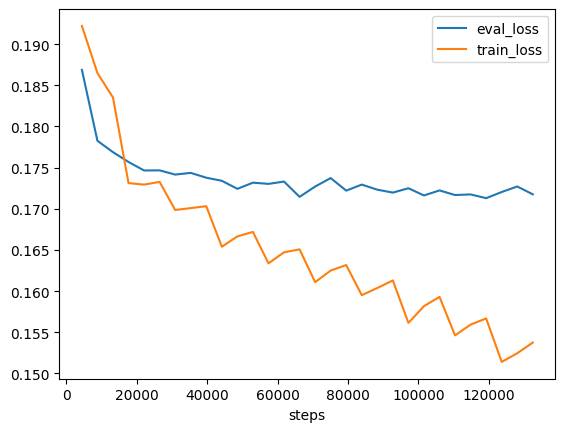

In [ ]:
df_metrics = df_metrics.set_index("steps")
df_metrics[['eval_loss','train_loss']].plot() 

In [ ]:
best_model = BSTRecommender(config=config)

In [ ]:
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()
best_model.to(config.device)

BSTRecommender(
  (embedding_layers): ModuleDict(
    (user): Embedding(6041, 32)
    (movie): Embedding(3884, 32)
    (occupation): Embedding(22, 32)
    (age_group): Embedding(8, 32)
    (position): Embedding(4, 32)
  )
  (transformer_layer): TransformerLayer(
    (transformer_blocks): ModuleList(
      (0-2): 3 x TransformerBlock(
        (multihead_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
        (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (mlp): MLP(
    (dropout): Dropout(p=

In [ ]:
best_model.eval()
prob_list= []
rating_list = []
eval_loss_list = []
pbar = tqdm(total = len(test_loader),desc = "",position=0, leave=True)
for inputs in test_loader:
    with torch.no_grad():
        probs = best_model(inputs)
        ratings = inputs['target_rating'].view(-1,1)
        
        loss = loss_func(probs, ratings)
        eval_loss_list.append(loss.item())

        probs = probs.cpu().numpy().flatten().tolist()
        prob_list.extend(probs)

        ratings = ratings.cpu().numpy().flatten().tolist()
        rating_list.extend(ratings)

        pbar.update(1)

 99%|█████████▉| 2315/2328 [00:07<00:00, 292.14it/s]

In [ ]:
prediction = pd.DataFrame()
prediction['real']=min_max_scaler.inverse_transform(np.array(rating_list).reshape(-1,1))[:,0]
prediction['prediction']=min_max_scaler.inverse_transform(np.array(prob_list).reshape(-1,1))[:,0]

In [ ]:
MAE = metrics.mean_absolute_error(prediction['real'],prediction['prediction'])
RMSE = metrics.mean_squared_error(prediction['real'],prediction['prediction'])

In [ ]:
print(f"MAE:{MAE},RMSE:{RMSE}")

MAE:0.6852583476560266,RMSE:0.9286585289246824


In [ ]:
"""show result: the model seems very good"""
prediction.iloc[:50]

,real,prediction
0,3.0,4.008994
1,4.0,4.948138
2,4.0,4.999993
3,4.0,3.908942
4,5.0,4.011354
5,4.0,2.989515
6,2.0,3.697369
7,5.0,5.000000
8,1.0,1.725742
9,5.0,4.034592
